<a href="https://colab.research.google.com/github/ManavBansal/Vyntelligence/blob/master/src/focalLoss2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import tensorflow as tf
import math
import h5py
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.regularizers import l2
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
K.clear_session()


In [51]:

def categorical_focal_loss(num_classes=3, gamma=2., alpha=.25, smooth_alpha=0.05):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        if smooth_alpha > 0:
            y_true = y_true * (1 - smooth_alpha) + smooth_alpha / num_classes

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

In [52]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/open_src_data/train/neg2.zip", 'r')
zip_ref.extractall("/content/train")
zip_ref = zipfile.ZipFile("/content/drive/My Drive/open_src_data/train/pos2.zip", 'r')
zip_ref.extractall("/content/train")
zip_ref = zipfile.ZipFile("/content/drive/My Drive/open_src_data/train/train_hard.zip", 'r')
zip_ref.extractall("/content/train")

In [53]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/open_src_data/cross_valid/cross_valid_neg (2).zip", 'r')
zip_ref.extractall("/content/cross_val")
zip_ref = zipfile.ZipFile("/content/drive/My Drive/open_src_data/cross_valid/cross_valid_positive (2).zip", 'r')
zip_ref.extractall("/content/cross_val")
zip_ref = zipfile.ZipFile("/content/drive/My Drive/open_src_data/cross_valid/hard_cross_val.zip", 'r')
zip_ref.extractall("/content/cross_val")
zip_ref.close()

In [54]:
#from keras.applications.vgg16 import VGG16
base_model=ResNet50(include_top = False, pooling = "avg")
from keras.applications.resnet import preprocess_input
model = Sequential()
model.add(base_model)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu',))
model.add(layers.Dense(3, activation='softmax'))
#model.layers[0].trainable = False


In [56]:
for layer in base_model.layers:
   layer.trainable = False


In [57]:
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [66]:


model.compile(optimizer='RMSprop', loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])

In [67]:
img_width, img_height = 400,400

train_data_dir = '/content/train'
validation_data_dir = '/cross_val'
nb_train_samples = 1282
nb_validation_samples = 503
epochs = 12
batch_size = 16
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [68]:
train_datagen=ImageDataGenerator(
		preprocessing_function=preprocess_input,
		rotation_range=20,
		zoom_range=0.15,
    channel_shift_range=150.0,
    brightness_range=(0.3, 0.9),
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")
#

In [69]:
train_generator = train_datagen.flow_from_directory(
    "/content/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    interpolation="bicubic",
    class_mode='categorical')

Found 2210 images belonging to 3 classes.


In [70]:
#
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = test_datagen.flow_from_directory(
    '/content/cross_val',
    target_size=(img_width, img_height),
    interpolation="bicubic",
    batch_size=batch_size,
    class_mode='categorical')

Found 409 images belonging to 3 classes.


In [71]:

#reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                         #     patience=2, min_lr=0.00001)
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
138/138 [==============================] - 161s 1s/step - loss: 0.1054 - accuracy: 0.5830 - val_loss: 0.0922 - val_accuracy: 0.7575
Epoch 2/20
138/138 [==============================] - 157s 1s/step - loss: 0.0880 - accuracy: 0.6841 - val_loss: 0.0792 - val_accuracy: 0.7650
Epoch 3/20
138/138 [==============================] - 164s 1s/step - loss: 0.0847 - accuracy: 0.7133 - val_loss: 0.0864 - val_accuracy: 0.7475
Epoch 4/20
138/138 [==============================] - 163s 1s/step - loss: 0.0792 - accuracy: 0.7461 - val_loss: 0.0770 - val_accuracy: 0.7525
Epoch 5/20
138/138 [==============================] - 160s 1s/step - loss: 0.0774 - accuracy: 0.7516 - val_loss: 0.0802 - val_accuracy: 0.7525
Epoch 6/20
138/138 [==============================] - 158s 1s/step - loss: 0.0773 - accuracy: 0.7621 - val_loss: 0.0777 - val_accuracy: 0.7550
Epoch 7/20
138/138 [==============================] - 156s 1s/step - loss: 0.0755 - accuracy: 0.7580 - val_loss: 0.0783 - val_accuracy: 0.7700

KeyboardInterrupt: ignored

In [ ]:
model.save_weights("my_weights_resnet50.h5")
!mv "/content/my_weights_resnet50.h5" "/content/drive/My Drive/open_src_data/cross_valid/my_weights_resnet50.h5"

In [ ]:
model.save("mymodel3_r.h5")
!mv "/content/mymodel3_r.h5" "/content/drive/My Drive/open_src_data/cross_valid/mymodel3_r.h5"

In [72]:
for layer in base_model.layers[:165]:
  layer.trainable = False
for layer in base_model.layers[165:]:
  layer.trainable= True

In [75]:


model.compile(optimizer='adam', loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])

In [76]:
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)

Epoch 1/50
138/138 [==============================] - 161s 1s/step - loss: 0.0782 - accuracy: 0.7475 - val_loss: 0.1112 - val_accuracy: 0.7250
Epoch 2/50
138/138 [==============================] - 159s 1s/step - loss: 0.0692 - accuracy: 0.7967 - val_loss: 0.1094 - val_accuracy: 0.7325
Epoch 3/50
138/138 [==============================] - 163s 1s/step - loss: 0.0657 - accuracy: 0.8077 - val_loss: 0.0747 - val_accuracy: 0.7850
Epoch 4/50
138/138 [==============================] - 164s 1s/step - loss: 0.0657 - accuracy: 0.7963 - val_loss: 0.0789 - val_accuracy: 0.7875
Epoch 5/50
138/138 [==============================] - 163s 1s/step - loss: 0.0604 - accuracy: 0.8232 - val_loss: 0.0907 - val_accuracy: 0.7175
Epoch 6/50
138/138 [==============================] - 161s 1s/step - loss: 0.0620 - accuracy: 0.8191 - val_loss: 0.0709 - val_accuracy: 0.7900
Epoch 7/50
138/138 [==============================] - 161s 1s/step - loss: 0.0580 - accuracy: 0.8327 - val_loss: 0.0850 - val_accuracy: 0.7250

In [ ]:
model.save_weights("my_weights_resnet50_f_3class.h5")
!mv "/content/my_weights_resnet50_f_3class.h5" "/content/drive/My Drive/open_src_data/cross_valid/my_weights_resnet50_f_3class.h5"

In [ ]:
for layer in base_model.layers:
   layer.trainable = False

In [ ]:
model.save("mymodel3_r_f_3class.h5")
!mv "/content/mymodel3_r_f_3class.h5" "/content/drive/My Drive/open_src_data/cross_valid/mymodel3_r_f_3class.h5"

In [ ]:


model.compile(optimizer='adam', loss=[focal_loss], metrics=['accuracy'])

In [ ]:

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=2, min_lr=0.00001)
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=[reduce_lr]
)

Epoch 1/20
138/138 [==============================] - 195s 1s/step - loss: 1.0277 - accuracy: 0.8902 - val_loss: 2.9017 - val_accuracy: 0.7650
Epoch 2/20
138/138 [==============================] - 191s 1s/step - loss: 1.0207 - accuracy: 0.8938 - val_loss: 3.0669 - val_accuracy: 0.7375
Epoch 3/20
138/138 [==============================] - 192s 1s/step - loss: 1.0218 - accuracy: 0.9006 - val_loss: 3.2306 - val_accuracy: 0.7600
Epoch 4/20
138/138 [==============================] - 191s 1s/step - loss: 0.9889 - accuracy: 0.9038 - val_loss: 3.0223 - val_accuracy: 0.7300
Epoch 5/20
  1/138 [..............................] - ETA: 0s - loss: 1.1297 - accuracy: 0.8750

KeyboardInterrupt: ignored

In [ ]:
for layer in base_model.layers[:167]:
  layer.trainable = False
for layer in base_model.layers[167:]:
  layer.trainable= True

In [ ]:


model.compile(optimizer='adam', loss=[focal_loss], metrics=['accuracy'])

In [ ]:
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

Epoch 1/20
138/138 [==============================] - 194s 1s/step - loss: 1.0671 - accuracy: 0.8861 - val_loss: 3.5223 - val_accuracy: 0.7575
Epoch 2/20
138/138 [==============================] - 191s 1s/step - loss: 1.1396 - accuracy: 0.8879 - val_loss: 2.6838 - val_accuracy: 0.7375
Epoch 3/20
138/138 [==============================] - 193s 1s/step - loss: 1.0663 - accuracy: 0.8947 - val_loss: 3.0516 - val_accuracy: 0.7000
Epoch 4/20
138/138 [==============================] - 194s 1s/step - loss: 1.0546 - accuracy: 0.8961 - val_loss: 2.9599 - val_accuracy: 0.7025
Epoch 5/20
138/138 [==============================] - 194s 1s/step - loss: 1.0089 - accuracy: 0.8979 - val_loss: 3.3149 - val_accuracy: 0.7200
Epoch 6/20
138/138 [==============================] - 194s 1s/step - loss: 0.9858 - accuracy: 0.8974 - val_loss: 3.0144 - val_accuracy: 0.7100
Epoch 7/20
138/138 [==============================] - 194s 1s/step - loss: 1.0756 - accuracy: 0.9011 - val_loss: 3.1533 - val_accuracy: 0.7225

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


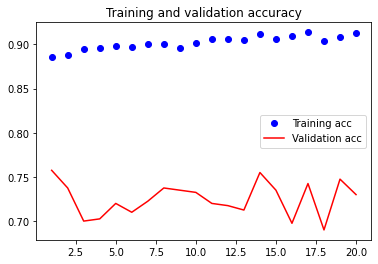

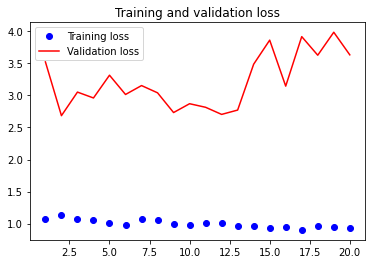

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
model.save_weights("my_weights_resnet50_f_3class_notgood.h5")
!mv "/content/my_weights_resnet50_f_3class_notgood.h5" "/content/drive/My Drive/open_src_data/cross_valid/my_weights_resnet50_f_3class_notgood.h5"

In [ ]:
model.save("mymodel3_r_f_3class_notgood.h5")
!mv "/content/mymodel3_r_f_3class_notgood.h5" "/content/drive/My Drive/open_src_data/cross_valid/mymodel3_r_f_3class_notgood.h5"